# Clustering Stocks Based On Value At Risk
Anggota Kelompok
1. Abdullah Nasih Jasir (5025211111)
2. Mohammad Ahnaf Fauzan (5025211170)
3. Al-Ferro Yudisthira Putra (5025211176)
# ---------------------------------------------------------------------------

### Import Libraries
Code di bawah guna melakukan import seluruh library yang dibutuhkan dalam final project ini

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random
import glob
import os
import matplotlib.dates as mdates
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Visualitation Style
plt.style.use('ggplot')
%matplotlib inline

# ---------------------------------------------------------------------------
## **PREPROCESSING**
# ---------------------------------------------------------------------------

### Import Data
Code berikut berguna untuk mengimport data dari file csv yang tersimpan di folder history

In [2]:
path = 'indonesia-stock-forecast/data/history'
all_rec = glob.iglob(path + '/*.csv', recursive=True)
count = 0

prices_df = pd.DataFrame()
for f in all_rec:
    count = count + 1
    df = pd.read_csv(f, index_col='Date', usecols=['Date', 'Close'])
    colname = os.path.basename(f).replace('.csv', '')
    df.rename(columns={'Close': colname}, inplace=True)
    prices_df = pd.concat([prices_df, df], axis=1, sort=False)

# Convert the 'Date' column to datetime format
prices_df.index = pd.to_datetime(prices_df.index)

# Define the date range
start_date = pd.to_datetime("2022-03-24")
end_date = pd.to_datetime("2023-03-24")

# Filter the data to include only the specified date range
prices_df = prices_df[(prices_df.index >= start_date) & (prices_df.index <= end_date)]

# Filter stocks with at least 100 data points within the date range
valid_stocks = prices_df.columns[prices_df.count() >= 200]

# Create a new DataFrame with the selected date range and valid stocks
prices_train = prices_df.loc[(prices_df.index >= start_date) & (prices_df.index <= end_date),valid_stocks]

#Interpolate to fill in the data that is null
prices_train = prices_train.interpolate(method='linear')
prices_train.head(10)

,WIIM,CSAP,MTEL,MAPB,ARII,KBRI,ARKA,AKRA,WIRG,TINS,...,GZCO,CMPP,SEMA,JSMR,CSMI,TLDN,ARGO,KPAL,FREN,BIMA
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,407.373260,488.559998,748.505615,1560.0,244.0,50.0,50.0,848.498108,NaN,1788.094360,...,160.0,640.0,261.476471,3810.0,2980.0,NaN,1475.0,50.0,71.0,216.0
2022-03-25,405.460724,480.679993,748.505615,1550.0,244.0,50.0,50.0,887.066162,NaN,1788.094360,...,156.0,760.0,261.476471,3840.0,3000.0,NaN,1425.0,50.0,68.0,212.0
2022-03-28,405.460724,488.559998,758.354370,1510.0,240.0,50.0,50.0,925.634216,NaN,1797.786011,...,158.0,765.0,267.419128,3830.0,3000.0,NaN,1415.0,50.0,72.0,210.0
2022-03-29,405.460724,470.830017,753.429993,1510.0,242.0,50.0,50.0,896.708191,NaN,1783.248657,...,152.0,720.0,273.361786,3830.0,3000.0,NaN,1415.0,50.0,73.0,210.0
2022-03-30,420.761139,482.649994,758.354370,1560.0,244.0,50.0,50.0,867.782166,NaN,1768.711304,...,145.0,760.0,273.361786,3830.0,2990.0,NaN,1375.0,50.0,78.0,206.0
2022-03-31,434.148987,486.589996,758.354370,1560.0,248.0,50.0,50.0,877.424133,NaN,1763.865479,...,136.0,765.0,275.342651,3850.0,2790.0,NaN,1380.0,50.0,77.0,202.0
2022-04-01,453.274475,486.589996,748.505615,1560.0,248.0,50.0,50.0,891.887207,NaN,1822.014893,...,140.0,760.0,271.380890,3880.0,2700.0,NaN,1390.0,50.0,73.0,238.0
2022-04-04,476.225098,486.589996,763.278748,1500.0,248.0,50.0,50.0,882.245117,226.0,1885.010132,...,144.0,800.0,277.323547,3840.0,2700.0,NaN,1330.0,50.0,78.0,224.0
2022-04-05,462.837250,488.559998,763.278748,1510.0,246.0,50.0,50.0,896.708191,282.0,1880.164307,...,146.0,790.0,281.285309,3850.0,2700.0,NaN,1330.0,50.0,77.0,220.0


# ---------------------------------------------------------------------------
## **FINDING VALUE AT RISK VALUE**
# ---------------------------------------------------------------------------
Untuk mendapatkan Nilai dari VaR, kita memerlukan beberapa pencaharian terlebih dahulu, yaitu
1. Expected Values
2. Mean of Expected Values
3. Standard Deviation

### Expected Values
Berikut merupakan algoritma pencarian expected values

In [3]:
# Expected Value = Value(t) - Value(t-1) / Value(t-1)
expected_df = (prices_train.diff() / prices_train.shift(1)).shift(-1)
expected_df.columns = [f'{col}' for col in expected_df.columns]
expected_df.dropna(how='all', inplace=True)
expected_df.head()

,WIIM,CSAP,MTEL,MAPB,ARII,KBRI,ARKA,AKRA,WIRG,TINS,...,GZCO,CMPP,SEMA,JSMR,CSMI,TLDN,ARGO,KPAL,FREN,BIMA
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-24,-0.004695,-0.016129,0.000000,-0.006410,0.000000,0.0,0.0,0.045454,NaN,0.000000,...,-0.025000,0.187500,0.000000,0.007874,0.006711,NaN,-0.033898,0.0,-0.042254,-0.018519
2022-03-25,0.000000,0.016393,0.013158,-0.025806,-0.016393,0.0,0.0,0.043478,NaN,0.005420,...,0.012821,0.006579,0.022727,-0.002604,0.000000,NaN,-0.007018,0.0,0.058824,-0.009434
2022-03-28,0.000000,-0.036290,-0.006494,0.000000,0.008333,0.0,0.0,-0.031250,NaN,-0.008086,...,-0.037975,-0.058824,0.022222,0.000000,0.000000,NaN,0.000000,0.0,0.013889,0.000000
2022-03-29,0.037736,0.025105,0.006536,0.033113,0.008264,0.0,0.0,-0.032258,NaN,-0.008152,...,-0.046053,0.055556,0.000000,0.000000,-0.003333,NaN,-0.028269,0.0,0.068493,-0.019048
2022-03-30,0.031818,0.008163,0.000000,0.000000,0.016393,0.0,0.0,0.011111,NaN,-0.002740,...,-0.062069,0.006579,0.007246,0.005222,-0.066890,NaN,0.003636,0.0,-0.012821,-0.019417


### Mean Expected Value
berikut merupakan pencarian dari mean expected values

In [4]:
# Calculate the mean (expected value) for each column in expected_df
expected_means = expected_df.mean()
expected_means.head()

WIIM    0.003005
CSAP    0.002019
MTEL   -0.000053
MAPB    0.001985
ARII    0.000777
dtype: float64

### Standard Deviation
berikut merupakan pencarian dari standard deviation

In [5]:
# Calculate the standard deviation of daily returns for each stock
std_deviation = expected_df.std()
std_deviation.head()

WIIM    0.031601
CSAP    0.029006
MTEL    0.014008
MAPB    0.026900
ARII    0.047397
dtype: float64

### Value at Risk
Dengan memanfaatkan hasil dari pencarian di atas, kita mampu menemukan nilai value-at-risk sebagaimana ditunjukkan dibawah

In [6]:
# Calculate Value at Risk
value_at_risk = std_deviation.copy()
value_at_risk = -(expected_means + std_deviation*0.01)
value_at_risk.head(10)

WIIM   -0.003321
CSAP   -0.002309
MTEL   -0.000087
MAPB   -0.002254
ARII   -0.001251
KBRI   -0.000000
ARKA   -0.000267
AKRA   -0.003004
WIRG   -0.000593
TINS    0.001810
dtype: float64

# ---------------------------------------------------------------------------
# **CLUSTERING**
# ---------------------------------------------------------------------------
Setelah mendapatkan nilai VaR, kita akan melakukan clustering. Terdapat beberapa metode clustering yang digunakan, yaitu,
1. K-Means Algorithm
2. Agglomerative Algorithm
3. Gaussian Mixture Model (GMM) Algorithm
# ---------------------------------------------------------------------------

### **K-Means Algorithm**
Code berikut berguna untuk melakukan clustering menggunakan metode K-Means

In [7]:
# Standardize the data
scaler_kmeans = StandardScaler()
var_data_standardized_kmeans = scaler_kmeans.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K = 8

# Perform K-means clustering
kmeans = KMeans(n_clusters=K, random_state=42)
clusters_kmeans = kmeans.fit_predict(var_data_standardized_kmeans)
clusters_kmeans = clusters_kmeans + 1

# Display the resulting clusters
result_df_kmeans = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_kmeans})
print(result_df_kmeans)

           VaR  Cluster
WIIM -0.003321        7
CSAP -0.002309        1
MTEL -0.000087        6
MAPB -0.002254        1
ARII -0.001251        1
...        ...      ...
TLDN  0.000541        6
ARGO  0.002371        3
KPAL -0.000000        6
FREN -0.000002        6
BIMA  0.002937        3

[782 rows x 2 columns]


/Users/ferroyudisthira/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Pin Point Graph of Every Stocks Based On K-Means Algorithm
Code berikut berguna untuk menunjukkan gambaran peta persebaran stock berdasarkan Expected Values dan VaR nya

/var/folders/92/cpb0j1l94536c_zzljx18zw80000gn/T/ipykernel_8172/2527293517.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10', num_clusters)


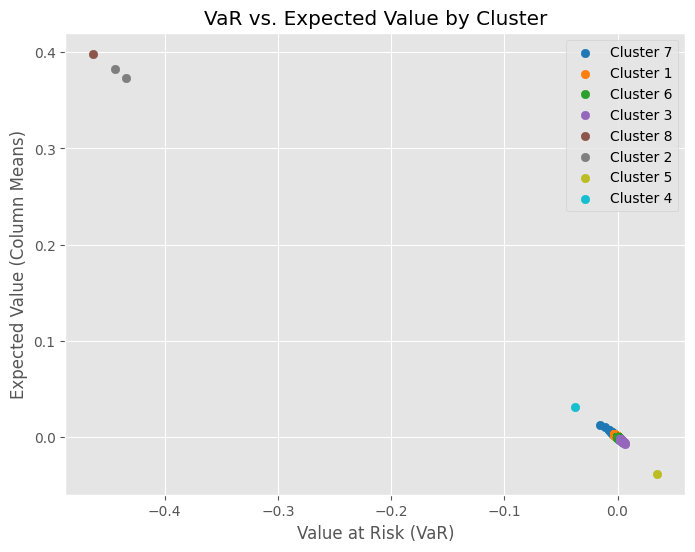

In [8]:
# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
num_clusters = result_df_kmeans['Cluster'].nunique()
color_palette = plt.cm.get_cmap('tab10', num_clusters) 

for i, cluster in enumerate(result_df_kmeans['Cluster'].unique()):
    cluster_data_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]
    plt.scatter(
        cluster_data_kmeans['VaR'],
        expected_means[cluster_data_kmeans.index],
        color=color_palette(i),
        label=f'Cluster {cluster}' 
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster Based On K-Means Algorithm
Untuk melihat detail persebaran lebih jelas, maka kita akan memilih 25 stock sebagai contoh

In [9]:
result_df_kmeans['Stocks'] = result_df_kmeans.index

# Function to pick 25 stocks randomly based on the cluster
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Create new DataFrame containing 25 random stocks per cluster or all of the stocks if there are less than 10 stocks available
newstockslist_kmeans = select_random_stocks_per_cluster(result_df_kmeans)
print(newstockslist_kmeans)

          VaR  Cluster Stocks
0   -0.000802        1   SMSM
1   -0.001518        1   PTBA
2   -0.000822        1   UNTR
3   -0.001844        1   CFIN
4   -0.000615        1   CSMI
..        ...      ...    ...
100 -0.005888        7   SMKM
101 -0.003833        7   PANR
102 -0.010831        7   SINI
103 -0.004964        7   SKRN
104 -0.462867        8   MYOR

[105 rows x 3 columns]


### Pin Point K-Means Clusters of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

/var/folders/92/cpb0j1l94536c_zzljx18zw80000gn/T/ipykernel_8172/2886269490.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_means[cluster_data_kmeans.index],


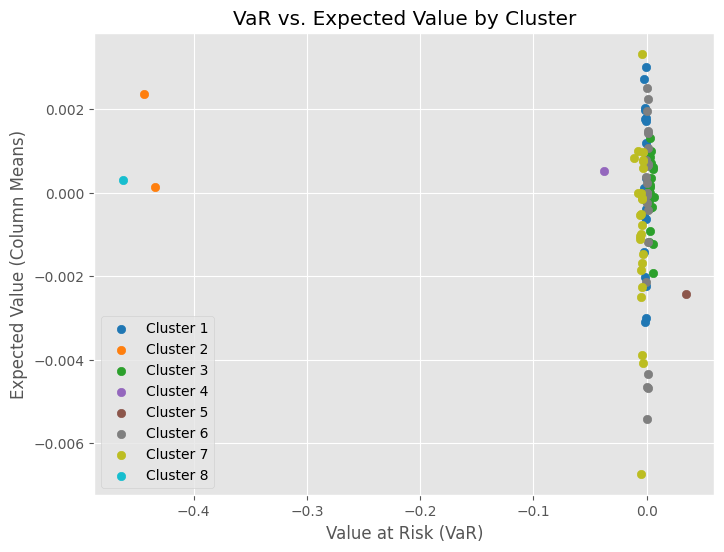

In [10]:
newclusters_kmeans = newstockslist_kmeans['Cluster'].unique()
num_clusters = len(newclusters_kmeans)

# Use the color palletes in order based on Matplotlib
color_palette = plt.cm.tab10(np.linspace(0, 1, num_clusters))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_kmeans):
    cluster_data_kmeans = newstockslist_kmeans[newstockslist_kmeans['Cluster'] == cluster]
    plt.scatter(
        cluster_data_kmeans['VaR'],
        expected_means[cluster_data_kmeans.index],
        color=color_palette[i],  
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on K-Means Algorithm

In [11]:
stock_name = "BBCA"
cluster_series = result_df_kmeans.loc[stock_name, 'Cluster'] if stock_name in result_df_kmeans.index else None

if cluster_series is not None:
    cluster = cluster_series
    print(f"The stock {stock_name} is in Cluster {cluster}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_kmeans = result_df_kmeans[result_df_kmeans['Cluster'] == cluster]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster}:")
    print(same_cluster_stocks_kmeans.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 1

Other stocks in Cluster 1:
           VaR  Cluster Stocks
CSAP -0.002309        1   CSAP
MAPB -0.002254        1   MAPB
ARII -0.001251        1   ARII
AKRA -0.003004        1   AKRA
WIRG -0.000593        1   WIRG


# ---------------------------------------------------------------------------

### **Agglomerative Algorithm**
Code di bawah berguna untuk melakukan clustering berdasarkan Algoritma Agglomerative 

In [12]:
# Standardize the data
scaler_aglo = StandardScaler()
var_data_standardized_aglo = scaler_aglo.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K = 8

# Perform Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=K)
clusters_aglo = agg_cluster.fit_predict(var_data_standardized_aglo)
clusters_aglo = clusters_aglo + 1

# Display the resulting clusters
result_df_aglo = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_aglo})
print(result_df_aglo)

           VaR  Cluster
WIIM -0.003321        3
CSAP -0.002309        7
MTEL -0.000087        1
MAPB -0.002254        7
ARII -0.001251        7
...        ...      ...
TLDN  0.000541        1
ARGO  0.002371        1
KPAL -0.000000        1
FREN -0.000002        1
BIMA  0.002937        4

[782 rows x 2 columns]


### Bar Plot Every Stocks Based On Agglomerative Algorithm
Code di bawah berguna untuk memvisualisasikan data persebaran berdasarkan Expected Values dan VaR dari algoritma Agglomerative

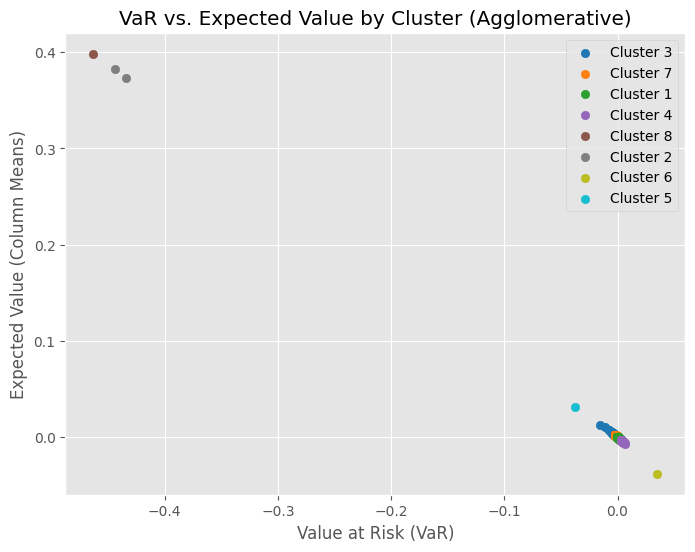

In [13]:
# Pick cluster count that is unique
num_clusters_aglo = result_df_aglo['Cluster'].nunique()

# Use the color palletes in order based on Matplotlib
color_palette_aglo = plt.cm.tab10(np.linspace(0, 1, num_clusters_aglo))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_aglo['Cluster'].unique()):
    cluster_data_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster]
    plt.scatter(
        cluster_data_aglo['VaR'],
        expected_means[cluster_data_aglo.index],
        color=color_palette_aglo[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (Agglomerative)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster Based On Agglomerative Algorithm
Untuk melihat data lebih jelas, maka diambil 25 stock per cluster untuk di visualisasikan

In [14]:
result_df_aglo['Stocks'] = result_df_aglo.index

# Function to pick 25 stocks randomly based on the cluster
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Create new DataFrame containing 25 random stocks per cluster or all of the stocks if there are less than 10 stocks available
new_stocks_list_aglo = select_random_stocks_per_cluster(result_df_aglo)
print(new_stocks_list_aglo)

          VaR  Cluster Stocks
0    0.000433        1   PSAB
1    0.001812        1   GSMF
2    0.002535        1   LFLO
3    0.000988        1   NPGF
4    0.000273        1   SSTM
..        ...      ...    ...
100 -0.002376        7   ENRG
101 -0.000259        7   IDPR
102 -0.001036        7   TRUS
103 -0.001550        7   SDMU
104 -0.462867        8   MYOR

[105 rows x 3 columns]


### Pin Point Agglomerative Clusters of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

/var/folders/92/cpb0j1l94536c_zzljx18zw80000gn/T/ipykernel_8172/1823860624.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_means[cluster_data_aglo.index],


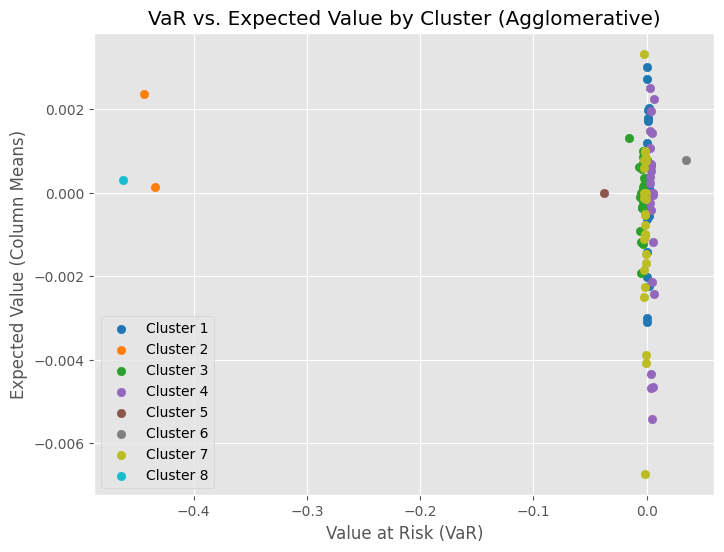

In [15]:
newclusters_aglo = new_stocks_list_aglo['Cluster'].unique()
num_clusters_aglo = len(newclusters_aglo)

# Use the color palletes in order based on Matplotlib
color_palette_aglo = plt.cm.tab10(np.linspace(0, 1, num_clusters_aglo))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_aglo):
    cluster_data_aglo = new_stocks_list_aglo[new_stocks_list_aglo['Cluster'] == cluster]
    plt.scatter(
        cluster_data_aglo['VaR'],
        expected_means[cluster_data_aglo.index],
        color=color_palette_aglo[i],  
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (Agglomerative)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on Agglomerative Algorithm

In [16]:
stock_name = "BBCA"
cluster_series_aglo = result_df_aglo.loc[stock_name, 'Cluster'] if stock_name in result_df_aglo.index else None

if cluster_series_aglo is not None:
    cluster_aglo = cluster_series_aglo
    print(f"The stock {stock_name} is in Cluster {cluster_aglo}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_aglo = result_df_aglo[result_df_aglo['Cluster'] == cluster_aglo]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster_aglo}:")
    print(same_cluster_stocks_aglo.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 7

Other stocks in Cluster 7:
           VaR  Cluster Stocks
CSAP -0.002309        7   CSAP
MAPB -0.002254        7   MAPB
ARII -0.001251        7   ARII
ARKA -0.000267        7   ARKA
WIRG -0.000593        7   WIRG


# ---------------------------------------------------------------------------

### **GMM Algorithm**
Code dibawah berguna untuk melakukan implementasi dari algoritma GMM dalam melakukan Clustering

In [17]:
# Standardize the data
scaler_gmm = StandardScaler()
var_data_standardized_gmm = scaler_gmm.fit_transform(np.array(value_at_risk).reshape(-1, 1))

K_gmm = 8

# Perform GMM Clustering
gmm_cluster = GaussianMixture(n_components=K_gmm, random_state=42)
clusters_gmm = gmm_cluster.fit_predict(var_data_standardized_gmm)
clusters_gmm = clusters_gmm + 1

# Display the resulting clusters
result_df_gmm = pd.DataFrame({'VaR': value_at_risk, 'Cluster': clusters_gmm})
print(result_df_gmm)


           VaR  Cluster
WIIM -0.003321        7
CSAP -0.002309        7
MTEL -0.000087        3
MAPB -0.002254        3
ARII -0.001251        3
...        ...      ...
TLDN  0.000541        3
ARGO  0.002371        1
KPAL -0.000000        3
FREN -0.000002        3
BIMA  0.002937        5

[782 rows x 2 columns]


### Bar Plot Every Stocks Based On GMM Algorithm
Berikut merupakan Visualisasi seluruh stock berdasarkan Expected Values dan VaR dari Algoritma GMM

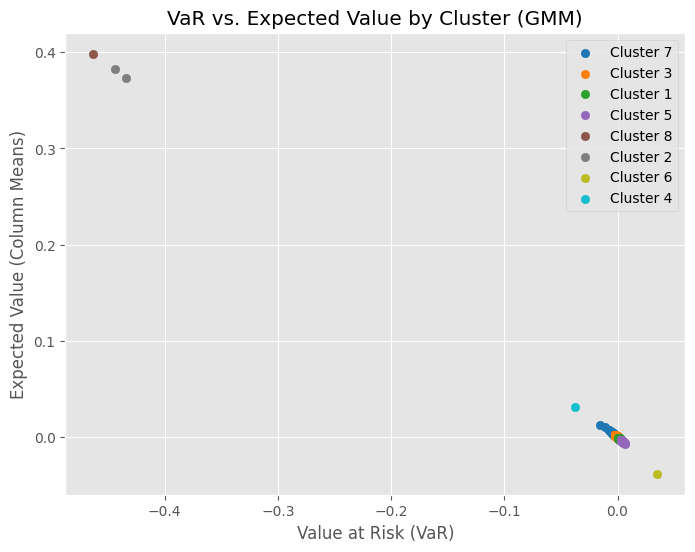

In [18]:
# Define colors for each cluster
num_clusters_gmm = len(result_df_gmm['Cluster'].unique())
color_palette_gmm = plt.cm.tab10(np.linspace(0, 1, num_clusters_gmm))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(result_df_gmm['Cluster'].unique()):
    cluster_data_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster]
    plt.scatter(
        cluster_data_gmm['VaR'],
        expected_means[cluster_data_gmm.index],
        color=color_palette_gmm[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster (GMM)')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Random 25 Stock Each Cluster Based On GMM Algorithm
Untuk melihat data lebih jelas, maka diambil 25 stock per cluster untuk di visualisasikan

In [19]:
result_df_gmm['Stocks'] = result_df_gmm.index

# Function to pick 25 stocks randomly based on the cluster 
def select_random_stocks_per_cluster(df):
    return df.groupby('Cluster').apply(lambda x: x.sample(n=25) if len(x) >= 25 else x).reset_index(drop=True)

# Create new DataFrame containing 25 random stocks per cluster or all of the stocks if there are less than 10 stocks available
newstockslist_gmm = select_random_stocks_per_cluster(result_df_gmm)
print(newstockslist_gmm)

          VaR  Cluster Stocks
0    0.000858        1   BHAT
1    0.001313        1   WEHA
2    0.000973        1   RODA
3    0.001437        1   TRIN
4    0.001799        1   KAEF
..        ...      ...    ...
100 -0.002309        7   CSAP
101 -0.003845        7   CAKK
102 -0.002783        7   RDTX
103 -0.003833        7   PANR
104 -0.462867        8   MYOR

[105 rows x 3 columns]


### Pin Point GMM Clusters of The Selected Stocks
Code di bawah melakukan penunjukan data dari 25 saham per cluster yang telah terpilih

/var/folders/92/cpb0j1l94536c_zzljx18zw80000gn/T/ipykernel_8172/442563314.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  expected_means[cluster_data_gmm.index],


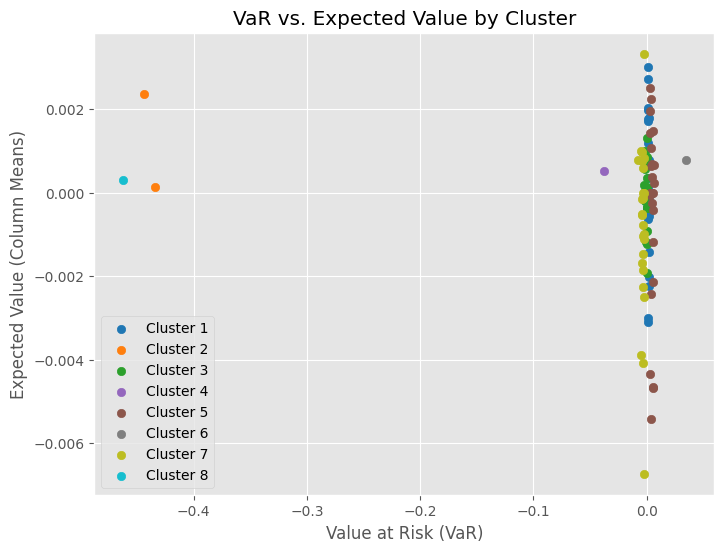

In [20]:
newclusters_gmm = newstockslist_gmm['Cluster'].unique()
num_clusters_gmm = len(newclusters_gmm)

# Use color palletes in order based on Matplotlib
color_palette_gmm = plt.cm.tab10(np.linspace(0, 1, num_clusters_gmm))

# Plot the graph for each cluster with a consistent color palette
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(newclusters_gmm):
    cluster_data_gmm = newstockslist_gmm[newstockslist_gmm['Cluster'] == cluster]
    plt.scatter(
        cluster_data_gmm['VaR'],
        expected_means[cluster_data_gmm.index],
        color=color_palette_gmm[i], 
        label=f'Cluster {cluster}'
    )

plt.title('VaR vs. Expected Value by Cluster')
plt.xlabel('Value at Risk (VaR)')
plt.ylabel('Expected Value (Column Means)')
plt.legend()
plt.grid(True)
plt.show()

### Test Clustering Based On Selected Stocks on GMM Algorithm

In [21]:
stock_name = "BBCA"
cluster_series_gmm = result_df_gmm.loc[stock_name, 'Cluster'] if stock_name in result_df_gmm.index else None

if cluster_series_gmm is not None:
    cluster_gmm = cluster_series_gmm
    print(f"The stock {stock_name} is in Cluster {cluster_gmm}\n")
    
    # Find stocks that are in the same cluster as the selected one
    same_cluster_stocks_gmm = result_df_gmm[result_df_gmm['Cluster'] == cluster_gmm]

    # Display stocks that are in the same cluster as the selected one
    print(f"Other stocks in Cluster {cluster_gmm}:")
    print(same_cluster_stocks_gmm.head(5))
else:
    print(f"The stock {stock_name} was not found in any cluster")

The stock BBCA is in Cluster 3

Other stocks in Cluster 3:
           VaR  Cluster Stocks
MTEL -0.000087        3   MTEL
MAPB -0.002254        3   MAPB
ARII -0.001251        3   ARII
KBRI -0.000000        3   KBRI
ARKA -0.000267        3   ARKA


# ---------------------------------------------------------------------------
# COMPARISON
# ---------------------------------------------------------------------------

### Mean VaR of Clusters Analysis Based On Algorithm
Untuk mengetahui persamaan cluster dari setiap algoritma, maka perlu dilakukannya analisis berdasarkan mean VaR dari setiap clusternya

### K-Means Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma K-Means

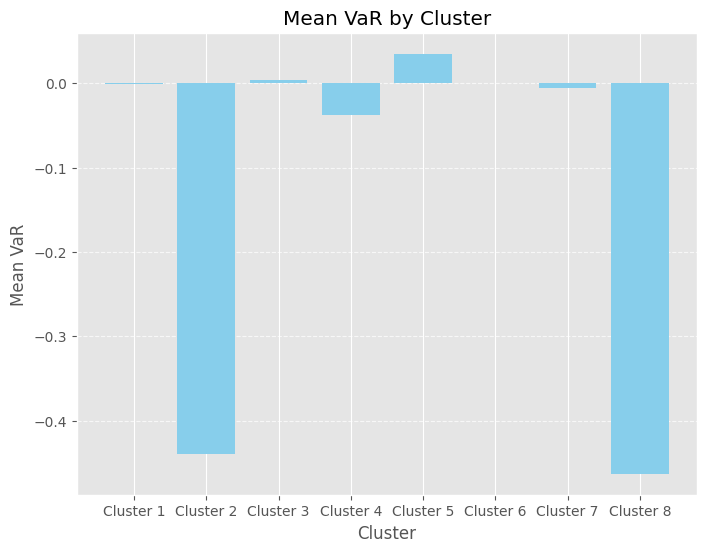

In [22]:
grouped_df_kmeans = result_df_kmeans.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels = [f'Cluster {label}' for label in grouped_df_kmeans['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels, grouped_df_kmeans['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()


### Agglomerative Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma Aggloemerative

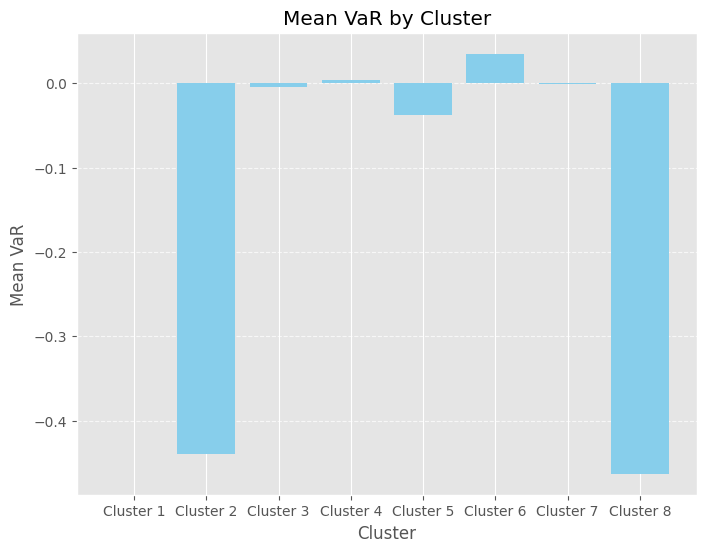

In [23]:
grouped_df_aglo = result_df_aglo.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels_aglo = [f'Cluster {label}' for label in grouped_df_aglo['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels_aglo, grouped_df_aglo['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels_aglo)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### GMM Algorithm
Berikut merupakan visualisasi dari Mean VaR algoritma GMM

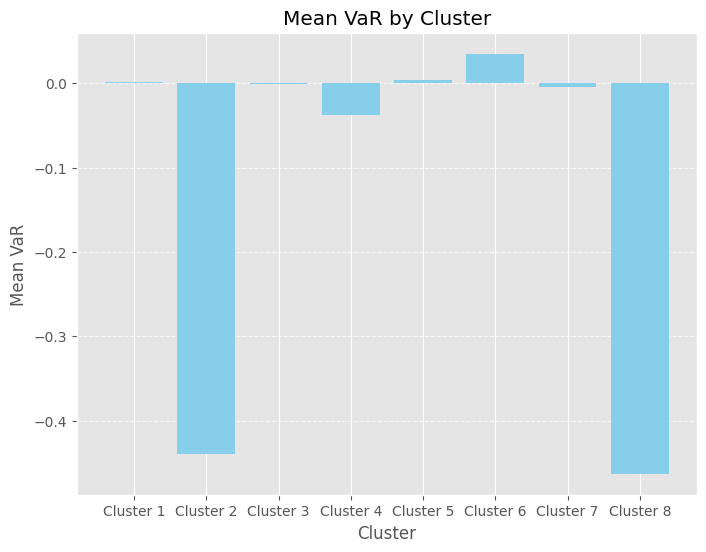

In [24]:
grouped_df_gmm = result_df_gmm.groupby('Cluster')['VaR'].mean().reset_index()
cluster_labels_gmm = [f'Cluster {label}' for label in grouped_df_gmm['Cluster']]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(cluster_labels_gmm, grouped_df_gmm['VaR'], color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(cluster_labels_gmm) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.show()

### Perbandingan 3 Algoritma
Berikut adalah grafik perbandingan Mean VaR pada setiap cluster

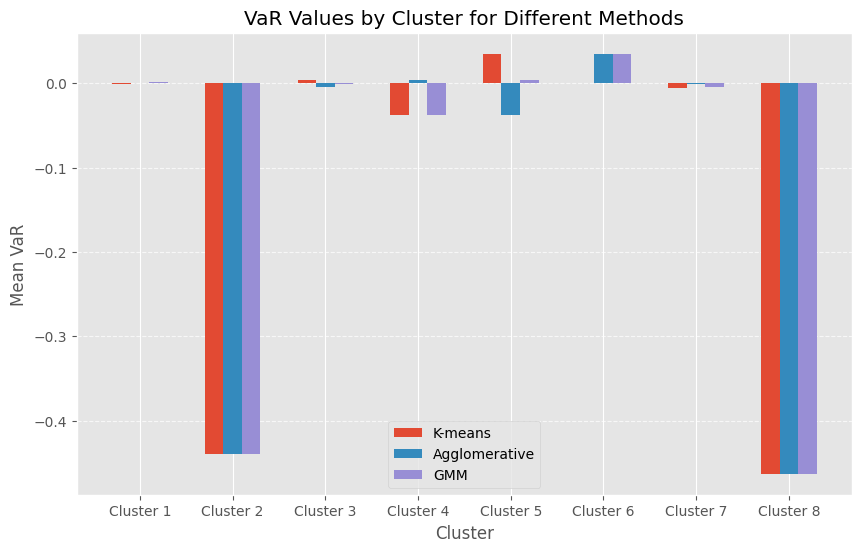

In [25]:
bar_width = 0.2

# Cluster position on x-axis
x_clusters = np.arange(len(grouped_df_kmeans))

plt.figure(figsize=(10, 6))

# Bar plot for K-means
plt.bar(x_clusters - bar_width, grouped_df_kmeans['VaR'], width=bar_width, label='K-means')

# Bar plot for Agglomerative clustering
plt.bar(x_clusters, grouped_df_aglo['VaR'], width=bar_width, label='Agglomerative')

# Bar plot ufor GMM
plt.bar(x_clusters + bar_width, grouped_df_gmm['VaR'], width=bar_width, label='GMM')

# Set labels and title
plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('VaR Values by Cluster for Different Methods')
plt.xticks(x_clusters, [f'Cluster {label}' for label in grouped_df_gmm['Cluster']])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display Plot
plt.show()


#### Note
Urutan Klaster dalam Clustering Tidak Mencerminkan Urutan Risiko yang Konsisten
Ketika melakukan proses clustering untuk mengelompokkan saham berdasarkan tingkat risiko, penting untuk dipahami bahwa urutan klaster tidak selalu menjamin urutan risiko yang konsisten. Setiap klaster hanya menunjukkan kesamaan dalam karakteristik risiko di dalamnya, namun tidak memastikan bahwa urutan klaster tersebut mengindikasikan tingkat risiko yang berurutan.

### Cluster Sorting Based On The Mean VaR
Guna menyamakan nama cluster sesuai dengan karakteristiknya, maka perlu dilakukannya pengurutan cluster berdasarkan nilai Mean VaR nya

In [26]:
def get_cluster_summary(df, algorithm_name):
    # Extract numeric columns
    numeric_columns = df.select_dtypes(include='number')
    
    # Calculate mean values for each cluster
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    
    # Explicitly sort the mean values
    cluster_means_sorted = cluster_means.sort_values()
    
    # Create a DataFrame with mean values and cluster counts
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    
    return summary

# Get cluster summaries for each algorithm
kmeans_summary = get_cluster_summary(result_df_kmeans, 'K-Means')
aglo_summary = get_cluster_summary(result_df_aglo, 'Agglomerative')
gmm_summary = get_cluster_summary(result_df_gmm, 'GMM')

# Display the individual summaries
print("K-Means Cluster Summary:")
print(kmeans_summary)

print("\nAgglomerative Cluster Summary:")
print(aglo_summary)

print("\nGMM Cluster Summary:")
print(gmm_summary)

K-Means Cluster Summary:
         Mean VaR  Counts
Cluster                  
8       -0.462867       1
2       -0.439187       2
4       -0.037331       1
7       -0.005132      41
1       -0.001409     231
6        0.000398     400
3        0.003369     105
5        0.034924       1

Agglomerative Cluster Summary:
         Mean VaR  Counts
Cluster                  
8       -0.462867       1
2       -0.439187       2
5       -0.037331       1
3       -0.004333      64
7       -0.001091     251
1        0.000653     395
4        0.004032      67
6        0.034924       1

GMM Cluster Summary:
         Mean VaR  Counts
Cluster                  
8       -0.462867       1
2       -0.439187       2
4       -0.037331       1
7       -0.004077      74
3       -0.000433     488
1        0.001468     146
5        0.003993      69
6        0.034924       1


### Change of Cluster Order based On The Sorted Mean VaR
Dengan data yang di dapatkan, maka kita akan melakukan perubahan nama cluster untuk menyesuaikan ketiga algoritma

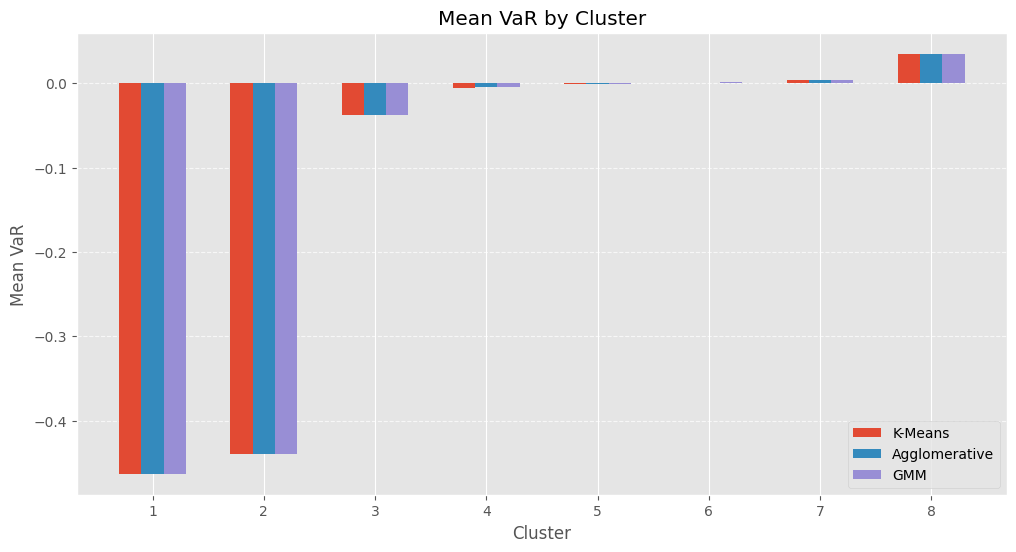

In [27]:
# Create copy of DataFrame without changing the original one
dfs = [result_df_kmeans, result_df_aglo, result_df_gmm]
new_dfs = [df.copy() for df in dfs]

# Determine the pattern of value subtitution
clusters = [kmeans_summary, aglo_summary, gmm_summary]

# Subtitute the value based on the pattern mentioned
for i, df in enumerate(new_dfs):
    df['Cluster'] = df['Cluster'].replace({clusters[i].index[j]: j+1 for j in range(8)})

# Save the result on the variable created earlier
newresult_df_kmeans, newresult_df_aglo, newresult_df_gmm = new_dfs

# Plot mean VaR for each cluster and algorithm after reassigning clusters
def get_cluster_summary(df, algorithm_name):
    numeric_columns = df.select_dtypes(include='number')
    cluster_means = numeric_columns.groupby('Cluster').mean()['VaR']
    cluster_means_sorted = cluster_means.sort_values()
    summary = pd.DataFrame({
        f'Mean VaR': cluster_means_sorted,
        f'Counts': df['Cluster'].value_counts().reindex(cluster_means_sorted.index)
    })
    return summary

# Get cluster summaries for each algorithm after reassigning clusters
new_kmeans_summary = get_cluster_summary(newresult_df_kmeans, 'K-Means')
new_aglo_summary = get_cluster_summary(newresult_df_aglo, 'Agglomerative')
new_gmm_summary = get_cluster_summary(newresult_df_gmm, 'GMM')

# Plot bar plot for mean VaR by cluster and algorithm after reassigning clusters
plt.figure(figsize=(12, 6))

bar_width = 0.2
x_kmeans = np.arange(len(new_kmeans_summary))
x_aglo = np.arange(len(new_aglo_summary)) + bar_width
x_gmm = np.arange(len(new_gmm_summary)) + 2 * bar_width

plt.bar(x_kmeans, new_kmeans_summary['Mean VaR'], width=bar_width, label='K-Means')
plt.bar(x_aglo, new_aglo_summary['Mean VaR'], width=bar_width, label='Agglomerative')
plt.bar(x_gmm, new_gmm_summary['Mean VaR'], width=bar_width, label='GMM')

plt.xlabel('Cluster')
plt.ylabel('Mean VaR')
plt.title('Mean VaR by Cluster')
plt.xticks(np.arange(len(new_gmm_summary)) + bar_width, new_gmm_summary.index)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


### Comparison of The Number of Stocks in Every Cluster
Berikut merupakan gambaran dari jumlah stocks di tiap Cluster

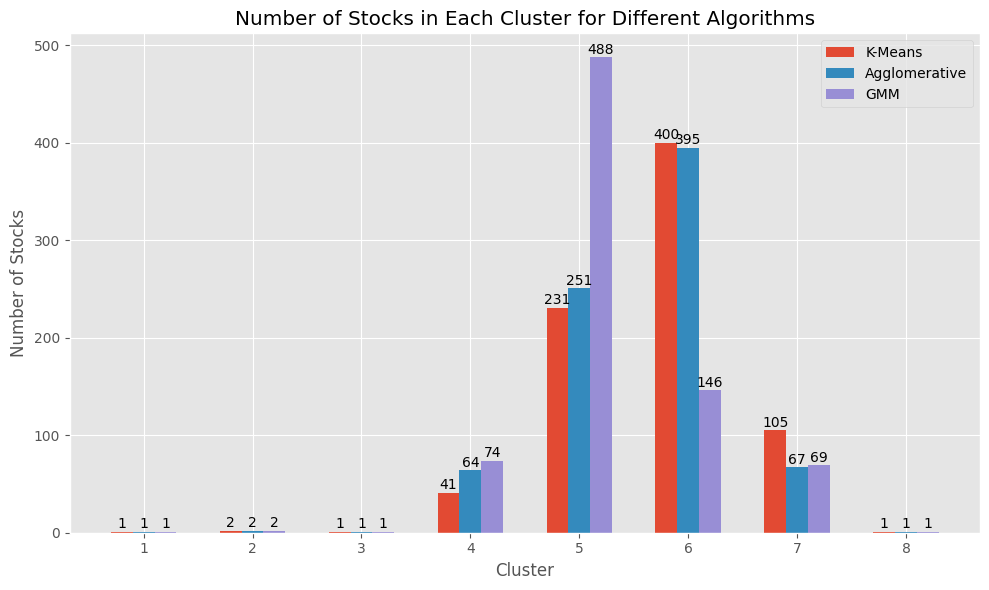

In [28]:
# Count the number of stocks in each cluster for each DataFrame
kmeans_cluster_counts = newresult_df_kmeans['Cluster'].value_counts().sort_index()
aglo_cluster_counts = newresult_df_aglo['Cluster'].value_counts().sort_index()
gmm_cluster_counts = newresult_df_gmm['Cluster'].value_counts().sort_index()

# Create a bar plot to compare the number of stocks in each cluster for each algorithm
plt.figure(figsize=(10, 6))

bar_width = 0.2
index = kmeans_cluster_counts.index  

plt.bar(index - bar_width, kmeans_cluster_counts, width=bar_width, label='K-Means')
plt.bar(index, aglo_cluster_counts, width=bar_width, label='Agglomerative')
plt.bar(index + bar_width, gmm_cluster_counts, width=bar_width, label='GMM')

# Display count values on top of each bar
for i, v in enumerate(kmeans_cluster_counts):
    plt.text(i + 1 - bar_width, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(aglo_cluster_counts):
    plt.text(i+1, v + 0.5, str(v), ha='center', va='bottom')
for i, v in enumerate(gmm_cluster_counts):
    plt.text(i + 1 + bar_width, v + 0.5, str(v), ha='center', va='bottom')

plt.xlabel('Cluster')
plt.ylabel('Number of Stocks')
plt.title('Number of Stocks in Each Cluster for Different Algorithms')
plt.xticks(index)
plt.legend()
plt.tight_layout()
plt.show()


### Stock Cluster 1
Berikut merupakan data Stock yang berada pada cluster 1 di setiap algoritma

In [29]:
# Choose stocks with the cluster of 1 in each algorithm
stocks_kmeans_cluster1 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 1]['Stocks']
stocks_aglo_cluster1 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 1]['Stocks']
stocks_gmm_cluster1 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 1]['Stocks']

# Find stocks that are in the cluster 1 on every algorithm
stocks_in_clusters1 = set(stocks_kmeans_cluster1) & set(stocks_aglo_cluster1) & set(stocks_gmm_cluster1)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 1 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters1))

Stock berikut memiliki cluster 1 di ketiga algoritma:
'MYOR'


### Stock Cluster 2
Berikut merupakan data Stock yang berada pada cluster 2 di setiap algoritma

In [30]:
# Choose stocks with the cluster of 2 in each algorithm
stocks_kmeans_cluster2 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 2]['Stocks']
stocks_aglo_cluster2 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 2]['Stocks']
stocks_gmm_cluster2 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 2]['Stocks']

# Find stocks that are in the cluster 2 on every algorithm
stocks_in_clusters2 = set(stocks_kmeans_cluster2) & set(stocks_aglo_cluster2) & set(stocks_gmm_cluster2)

# Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 2 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters2))

Stock berikut memiliki cluster 2 di ketiga algoritma:
'SIDO', 'SRAJ'


### Stock Cluster 3
Berikut merupakan data Stock yang berada pada cluster 3 di setiap algoritma

In [31]:
# Choose stocks with the cluster of 3 in each algorithm
stocks_kmeans_cluster3 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 3]['Stocks']
stocks_aglo_cluster3 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 3]['Stocks']
stocks_gmm_cluster3 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 3]['Stocks']

# Find stocks that are in the cluster 3 on every algorithm
stocks_in_clusters3 = set(stocks_kmeans_cluster3) & set(stocks_aglo_cluster3) & set(stocks_gmm_cluster3)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 3 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters3))

Stock berikut memiliki cluster 3 di ketiga algoritma:
'EXCL'


### Stock Cluster 4
Berikut merupakan data Stock yang berada pada cluster 4 di setiap algoritma

In [32]:
# Choose stocks with the cluster of 4 in each algorithm
stocks_kmeans_cluster4 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 4]['Stocks']
stocks_aglo_cluster4 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 4]['Stocks']
stocks_gmm_cluster4 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 4]['Stocks']

# Find stocks that are in the cluster 4 on every algorithm
stocks_in_clusters4 = set(stocks_kmeans_cluster4) & set(stocks_aglo_cluster4) & set(stocks_gmm_cluster4)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 4 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters4))

Stock berikut memiliki cluster 4 di ketiga algoritma:
'SMKM', 'PNIN', 'OASA', 'MRAT', 'SULI', 'PICO', 'SKRN', 'PNBN', 'BUMI', 'LTLS', 'RAJA', 'SINI', 'ASBI', 'AMRT', 'TMAS', 'BMSR', 'MPRO', 'FMII', 'NZIA', 'BELL', 'BYAN', 'IBOS', 'PANI', 'OKAS', 'MICE', 'GLVA', 'RISE', 'LION', 'SDPC', 'ETWA', 'PTIS', 'SNLK', 'NICL', 'LUCY', 'CAKK', 'WIIM', 'ZONE', 'YPAS', 'OBMD', 'PANR', 'PNLF'


### Stock Cluster 5
Berikut merupakan data Stock yang berada pada cluster 5 di setiap algoritma

In [33]:
# Choose stocks with the cluster of 5 in each algorithm
stocks_kmeans_cluster5 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 5]['Stocks']
stocks_aglo_cluster5 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 5]['Stocks']
stocks_gmm_cluster5 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 5]['Stocks']

# Find stocks that are in the cluster 5 on every algorithm
stocks_in_clusters5 = set(stocks_kmeans_cluster5) & set(stocks_aglo_cluster5) & set(stocks_gmm_cluster5)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 5 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters5))

Stock berikut memiliki cluster 5 di ketiga algoritma:
'POWR', 'TUGU', 'IGAR', 'BTON', 'BMTR', 'KOBX', 'PJAA', 'ICBP', 'MPMX', 'ARII', 'NRCA', 'MYTX', 'UNTR', 'AKPI', 'ARTA', 'PLIN', 'AHAP', 'MASA', 'SPTO', 'APLN', 'PSSI', 'ASJT', 'LAND', 'AIMS', 'PGAS', 'ASRM', 'MKPI', 'SOTS', 'WAPO', 'ROTI', 'ENZO', 'CITA', 'BLUE', 'BPII', 'NISP', 'ESSA', 'STTP', 'SSIA', 'PGUN', 'SFAN', 'IBST', 'IPCC', 'HDFA', 'CEKA', 'GPSO', 'BISI', 'CLEO', 'LPLI', 'ASGR', 'BSIM', 'TOTL', 'BDMN', 'FAPA', 'MLIA', 'HMSP', 'INTA', 'MAPB', 'IMPC', 'FIMP', 'DNET', 'BFIN', 'ADMF', 'SDMU', 'DWGL', 'GOLD', 'CASA', 'CMRY', 'IMAS', 'PTPW', 'WOMF', 'DEWA', 'INCI', 'INDR', 'SCNP', 'MFIN', 'RELI', 'SMSM', 'PTBA', 'ENAK', 'IDEA', 'INDF', 'INRU', 'MINA', 'EAST', 'DSNG', 'SOSS', 'DRMA', 'HOPE', 'INDO', 'BUDI', 'UNVR', 'KEJU', 'GDST', 'MTLA', 'SMAR', 'SHIP', 'NIRO', 'PPGL', 'SAMF', 'BINA', 'PMJS', 'KEEN', 'ASHA', 'PNBS', 'CASS', 'TCID', 'STAA', 'KKGI', 'LEAD', 'INTD', 'SHID', 'UANG', 'DILD', 'FLMC', 'BRIS', 'AGII', 'IFII', 'PUDP', 'B

### Stock Cluster 6
Berikut merupakan data Stock yang berada pada cluster 6 di setiap algoritma

In [34]:
# Choose stocks with the cluster of 6 in each algorithm
stocks_kmeans_cluster6 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 6]['Stocks']
stocks_aglo_cluster6 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 6]['Stocks']
stocks_gmm_cluster6 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 6]['Stocks']

# Find stocks that are in the cluster 6 on every algorithm
stocks_in_clusters6 = set(stocks_kmeans_cluster6) & set(stocks_aglo_cluster6) & set(stocks_gmm_cluster6)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 6 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters6))

Stock berikut memiliki cluster 6 di ketiga algoritma:
'BSML', 'AGRS', 'ZBRA', 'ATIC', 'MCOR', 'SCMA', 'ADCP', 'KIJA', 'KPIG', 'BANK', 'ACST', 'LPPS', 'AKSI', 'GEMA', 'GGRP', 'HOKI', 'RBMS', 'RODA', 'SMBR', 'PRAS', 'KICI', 'BTPS', 'CTBN', 'MAIN', 'MLPT', 'GMFI', 'PNSE', 'HRUM', 'FORU', 'POLY', 'IKAN', 'BNLI', 'CLAY', 'JPFA', 'SAPX', 'GSMF', 'WGSH', 'CITY', 'DNAR', 'BBTN', 'ANJT', 'WSBP', 'TRIM', 'DIVA', 'WEHA', 'SOFA', 'CSIS', 'SAME', 'ADMG', 'POLA', 'BBSI', 'BACA', 'LABA', 'BKSW', 'INDX', 'IMJS', 'BAJA', 'BHAT', 'JAWA', 'CBMF', 'TBIG', 'NATO', 'KAEF', 'DVLA', 'ISSP', 'PURE', 'DART', 'BMHS', 'PSKT', 'TIFA', 'LPCK', 'PMMP', 'TIRT', 'PPRE', 'LMPI', 'PTDU', 'SLIS', 'ADHI', 'JSKY', 'BNII', 'LSIP', 'TRIN', 'NOBU', 'VINS', 'FILM', 'AALI', 'CPRO', 'TRJA', 'BVIC', 'SMRA', 'PEGE', 'SMCB', 'ADMR', 'SATU', 'WMPP', 'PTPP', 'TINS', 'LPKR', 'AMOR', 'NPGF', 'BWPT', 'MARK', 'PEHA', 'INPC', 'UVCR', 'ICON', 'WEGE', 'MSIN', 'PAMG', 'MNCN'


### Stock Cluster 7
Berikut merupakan data Stock yang berada pada cluster 7 di setiap algoritma

In [35]:
# Choose stocks with the cluster of 7 in each algorithm
stocks_kmeans_cluster7 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 7]['Stocks']
stocks_aglo_cluster7 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 7]['Stocks']
stocks_gmm_cluster7 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 7]['Stocks']

# Find stocks that are in the cluster 7 on every algorithm
stocks_in_clusters7 = set(stocks_kmeans_cluster7) & set(stocks_aglo_cluster7) & set(stocks_gmm_cluster7)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 7 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters7))

Stock berikut memiliki cluster 7 di ketiga algoritma:
'MSKY', 'BCAP', 'BBYB', 'KBLV', 'KARW', 'UFOE', 'ATAP', 'WMUU', 'INPS', 'POLL', 'AYLS', 'BIMA', 'BBKP', 'EMTK', 'LUCK', 'ECII', 'BBHI', 'CENT', 'PSDN', 'HDIT', 'KIOS', 'MLPL', 'MARI', 'NICK', 'FUJI', 'IATA', 'FIRE', 'NANO', 'GIAA', 'APEX', 'BOLA', 'PCAR', 'SEMA', 'WIFI', 'CASH', 'ASSA', 'MGLV', 'ASMI', 'IPPE', 'HOMI', 'PTSP', 'KJEN', 'WSKT', 'SGER', 'ALTO', 'TNCA', 'NASI', 'IPTV', 'MPPA', 'ASLC', 'PRIM', 'URBN', 'DFAM', 'AGRO', 'INAF', 'ABBA', 'OLIV', 'BNBA', 'GOTO', 'TELE', 'BGTG', 'CMPP', 'JAST', 'ARTO', 'TECH', 'BESS', 'TOYS'


### Stock Cluster 8
Berikut merupakan data Stock yang berada pada cluster 8 di setiap algoritma

In [36]:
# Choose stocks with the cluster of 8 in each algorithm
stocks_kmeans_cluster8 = newresult_df_kmeans[newresult_df_kmeans['Cluster'] == 8]['Stocks']
stocks_aglo_cluster8 = newresult_df_aglo[newresult_df_aglo['Cluster'] == 8]['Stocks']
stocks_gmm_cluster8 = newresult_df_gmm[newresult_df_gmm['Cluster'] == 8]['Stocks']

# Find stocks that are in the cluster 8 on every algorithm
stocks_in_clusters8 = set(stocks_kmeans_cluster8) & set(stocks_aglo_cluster8) & set(stocks_gmm_cluster8)

#  Display and Check if the stocks are in the same cluster on every algorithm
print("Stock berikut memiliki cluster 8 di ketiga algoritma:")
print(', '.join(f"'{stock}'" for stock in stocks_in_clusters8))

Stock berikut memiliki cluster 8 di ketiga algoritma:
'SCPI'


# ---------------------------------------------------------------------------
## Features
# ---------------------------------------------------------------------------

### Note
1. Nilai VaR Mendekati -1:

Jika nilai VaR mendekati -1, itu menunjukkan bahwa kemungkinan kerugian besar dalam periode tertentu relatif tinggi. Pada level kepercayaan tertentu (misalnya, 95% atau 99%), ada kemungkinan tinggi bahwa kerugian besar akan terjadi. Ini menandakan risiko signifikan terkait investasi tersebut, dengan potensi kerugian yang lebih besar pada periode tertentu. Bagi investor yang menyukai risiko tinggi, nilai mendekati -1 pada VaR mungkin dianggap sebagai kesempatan untuk mendapatkan keuntungan besar, namun juga membawa risiko kerugian besar.

2. Nilai VaR Mendekati 1:

Ketika nilai VaR mendekati 1, itu menunjukkan bahwa risiko investasi relatif lebih rendah. Ini menandakan kemungkinan kerugian besar dalam periode tertentu cenderung lebih rendah. Pada level kepercayaan tertentu, risiko kerugian besar juga relatif lebih rendah. Bagi sebagian investor yang ingin menghindari risiko tinggi, mendekati nilai 1 pada VaR mungkin dianggap sebagai perlindungan terhadap kerugian besar, meskipun juga dapat membatasi potensi keuntungan.

### Merging All The Clusters Into One Data Frame
Code dibawah berguna untuk melakukan penyatuan seluruh cluster kedalam satu dataframe

In [37]:
# Merge three DataFrame based on 'Stock' and 'Cluster' Columns
finalresult_df = pd.merge(newresult_df_kmeans, newresult_df_aglo, on=['VaR', 'Stocks', 'Cluster'])
finalresult_df = pd.merge(finalresult_df, newresult_df_gmm, on=['VaR', 'Stocks', 'Cluster'])

print(finalresult_df)


          VaR  Cluster Stocks
0   -0.003321        4   WIIM
1   -0.002254        5   MAPB
2   -0.001251        5   ARII
3   -0.000593        5   WIRG
4    0.001810        6   TINS
..        ...      ...    ...
416  0.000909        6   WSBP
417  0.005207        7   CMPP
418  0.004045        7   SEMA
419 -0.000615        5   CSMI
420  0.002937        7   BIMA

[421 rows x 3 columns]


### Feature 1
#### Testing a specific Stock to where it falls in cluster while also recommending some stocks that fall in the same cluster.

The stock BBCA is in Cluster 5
Cluster 5: Investasi dalam klaster ini menunjukkan tingkat risiko yang terbilang cukup terkendali.
Potensi fluktuasi nilai yang sedikit dapat dikendali dengan risiko kerugian atau keuntungan yang sedang.
5 saham dengan nilai VaR tertinggi di Cluster 5:
          VaR Stocks  Cluster
189 -0.000499   ASJT        5
366 -0.000500   FLMC        5
52  -0.000520   ELSA        5
390 -0.000521   SPTO        5
21  -0.000522   PNBS        5



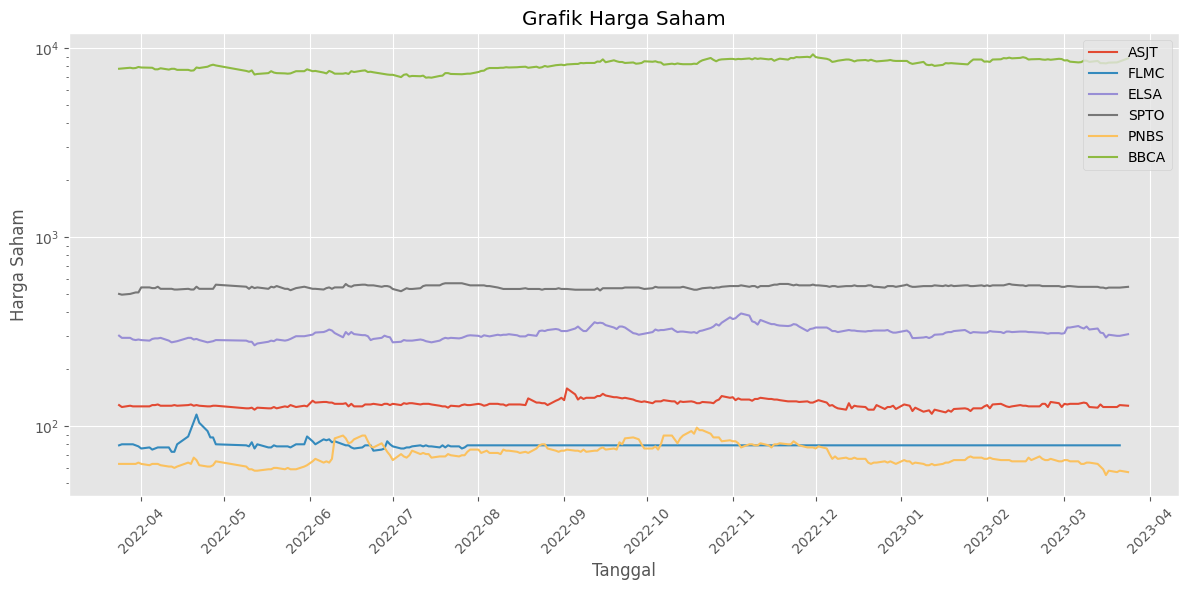

In [38]:
stock_name = "BBCA"
cluster_final = finalresult_df[finalresult_df.Stocks == stock_name]['Cluster']

if not cluster_final.empty:
    clusters_found = cluster_final.unique()
    for cluster in clusters_found:
        if stock_name in finalresult_df[finalresult_df['Cluster'] == cluster]['Stocks'].values:
            print(f"The stock {stock_name} is in Cluster {cluster}")

        if cluster == 1:
            print(f"Cluster {cluster}: Investasi dalam klaster ini memiliki risiko yang ekstrem.\nPotensi fluktuasi nilai yang ekstrem dengan risiko kerugian atau keuntungan yang ekstrem.")
        elif cluster == 2:
            print(f"Cluster {cluster}: Investasi dalam klaster ini memiliki risiko yang sangat tinggi.\nPotensi fluktuasi nilai yang sangat besar dengan risiko kerugian atau keuntungan yang sangat tinggi.")
        elif cluster == 3:
            print(f"Cluster {cluster}: Investasi dalam klaster ini memiliki risiko yang tinggi.\nPotensi fluktuasi nilai yang besar dengan risiko kerugian atau keuntungan yang tinggi.")
        elif cluster == 4:
            print(f"Cluster {cluster}: Investasi dalam klaster ini menunjukkan tingkat risiko yang terbilang cukup tinggi.\nPotensi fluktuasi nilai yang besar dengan risiko kerugian atau keuntungan yang besar.")
        elif cluster == 5:
            print(f"Cluster {cluster}: Investasi dalam klaster ini menunjukkan tingkat risiko yang terbilang cukup terkendali.\nPotensi fluktuasi nilai yang sedikit dapat dikendali dengan risiko kerugian atau keuntungan yang sedang.")
        elif cluster == 6:
            print(f"Cluster {cluster}: Investasi dalam klaster ini cenderung memiliki risiko yang relatif terkendali.\nPotensi fluktuasi nilai yang masih dapat diantisipasi, dengan risiko kerugian atau keuntungan yang moderat dalam jangka waktu tertentu.")
        elif cluster == 7:
            print(f"Cluster {cluster}: Investasi dalam klaster ini menunjukkan tingkat risiko yang moderat.\nPotensi fluktuasi nilai yang tidak besar dengan risiko kerugian atau keuntungan yang relatif kecil.")
        elif cluster == 8:
            print(f"Cluster {cluster}: Investasi dalam klaster ini memiliki nilai VaR paling rendah.\nPotensi kerugian atau keuntungan relatif stabil dalam jangka waktu tertentu")
        
        # Filter DataFrame based on the cluster
        same_cluster_final = finalresult_df[finalresult_df['Cluster'] == cluster]

        # Sort the VaR value descending
        sorted_cluster = same_cluster_final.sort_values(by='VaR', ascending=False)

        # Mengambil 5 saham dengan nilai VaR tertinggi Take 5 stocks with the highest VaR value
        top_5_highest_var = sorted_cluster.head(5)

        # Display VaRs, Stocks, and Clusters that have the highest VaR value
        print(f"5 saham dengan nilai VaR tertinggi di Cluster {cluster}:")
        print(top_5_highest_var[['VaR', 'Stocks', 'Cluster']])     
        print()
   
    # If not found
    else:
        cluster = clusters_found[0]

else:
    print(f"Saham {stock_name} tidak ditemukan di cluster manapun")

# Take date and stock's name that is chosen from "top_5_highest_var"
additional_stocksfix = top_5_highest_var['Stocks'].tolist()

# Add chosen stock's name to the list off selected stocks
stocks_to_plot = additional_stocksfix + [stock_name]

# Filter DataFrame for the chosen stocks
selected_stocks = prices_df[stocks_to_plot]

# Create graph
plt.figure(figsize=(12, 6))

# Plot chosen stock's close price
for stock in stocks_to_plot:
    plt.semilogy(selected_stocks.index, selected_stocks[stock], label=stock)

plt.title('Grafik Harga Saham')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)

# Format tanggal on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)  # Rotate date's label to improve the layouting
plt.tight_layout()  # organize the plotting to imporve the layouting
plt.show()


### Feature 2
#### Giving some stocks recommendation depending on the cluster risk level.

In [39]:
# Memilih tingkat risiko
tingkat_resiko = "Resiko Sangat Rendah"  # adjust the input

# Dictionary for the mapping of the risk level
tingkat_resiko_to_cluster = {
    "Resiko Ekstream": 1,
    "Resiko Sangat Tinggi": 2,
    "Resiko Tinggi": 3,
    "Resiko Sedang Tinggi": 4,
    "Resiko Sedang Rendah": 5,
    "Resiko Rendah": 6,
    "Resiko Sangat Rendah": 7,
    "Resiko Moderat": 8
}

# Check if the result is valid
if tingkat_resiko in tingkat_resiko_to_cluster:
    cluster = tingkat_resiko_to_cluster[tingkat_resiko]
    emiten_cluster = finalresult_df[finalresult_df['Cluster'] == cluster]['Stocks']
    
    if not emiten_cluster.empty:
        if len(emiten_cluster) < 10:
            print(f"Rekomendasi emiten untuk tingkat {tingkat_resiko}:")
            for emiten in emiten_cluster:
                print(emiten)
        else:
            emiten_rekomendasi = random.sample(emiten_cluster.tolist(), k=10)
            print(f"Rekomendasi 10 emiten untuk tingkat '{tingkat_resiko}':")
            for emiten in emiten_rekomendasi:
                print(emiten)
    else:
        print(f"Tidak ada emiten untuk tingkat '{tingkat_resiko}'")
else:
    print("Tingkat risiko tidak valid")


Rekomendasi 10 emiten untuk tingkat 'Resiko Sangat Rendah':
BBHI
ASMI
PCAR
PRIM
ATAP
AYLS
MPPA
EMTK
TNCA
CENT


# ---------------------------------------------------------------------------
## EVALUATION
# ---------------------------------------------------------------------------


### Silhouette Score

Silhouette Score K-Means: 0.5335918026392378
Silhouette Score GMM: 0.5223105915760385
Silhouette Score Agglomerative Clustering: 0.49677125856302495


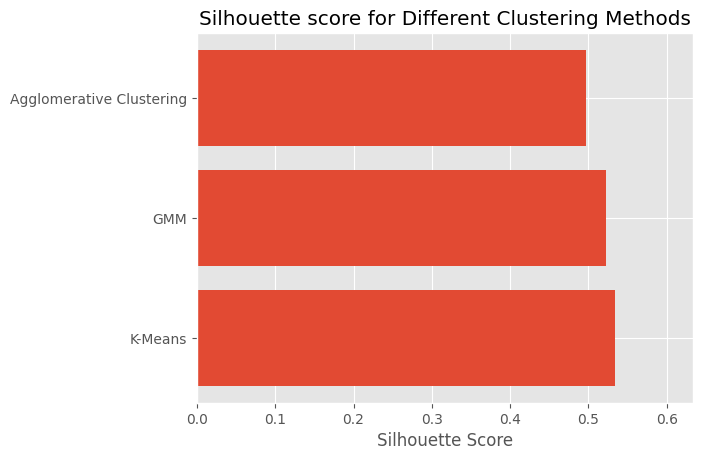

In [54]:
# Take the result of clustering from the all the algorithms
test1_clusters_kmeans = result_df_kmeans['Cluster']  # Clustering result of K-Means
test1_clusters_gmm = result_df_gmm['Cluster']   # Clustering result of GMM
test1_clusters_aglo = result_df_aglo['Cluster']   # Clustering result of Agglomerical

# Count the silhouette score of every clustering method
silhouette_kmeans = silhouette_score(var_data_standardized_kmeans, test1_clusters_kmeans)
silhouette_gmm = silhouette_score(var_data_standardized_gmm, test1_clusters_gmm)
silhouette_aglo = silhouette_score(var_data_standardized_aglo, test1_clusters_aglo)

# Display the result
print(f"Silhouette Score K-Means: {silhouette_kmeans}")
print(f"Silhouette Score GMM: {silhouette_gmm}")
print(f"Silhouette Score Agglomerative Clustering: {silhouette_aglo}")

methods = ['K-Means', 'GMM', 'Agglomerative']
scores = [silhouette_kmeans, silhouette_gmm, silhouette_aglo]

# Create a bar chart
plt.barh(methods, scores)
plt.xlabel('Silhouette Score')
plt.title('Silhouette score for Different Clustering Methods')
plt.xlim([0, max(scores) + 0.1])  # Adjust the x-axis limits if needed

# Display the plot
plt.show()

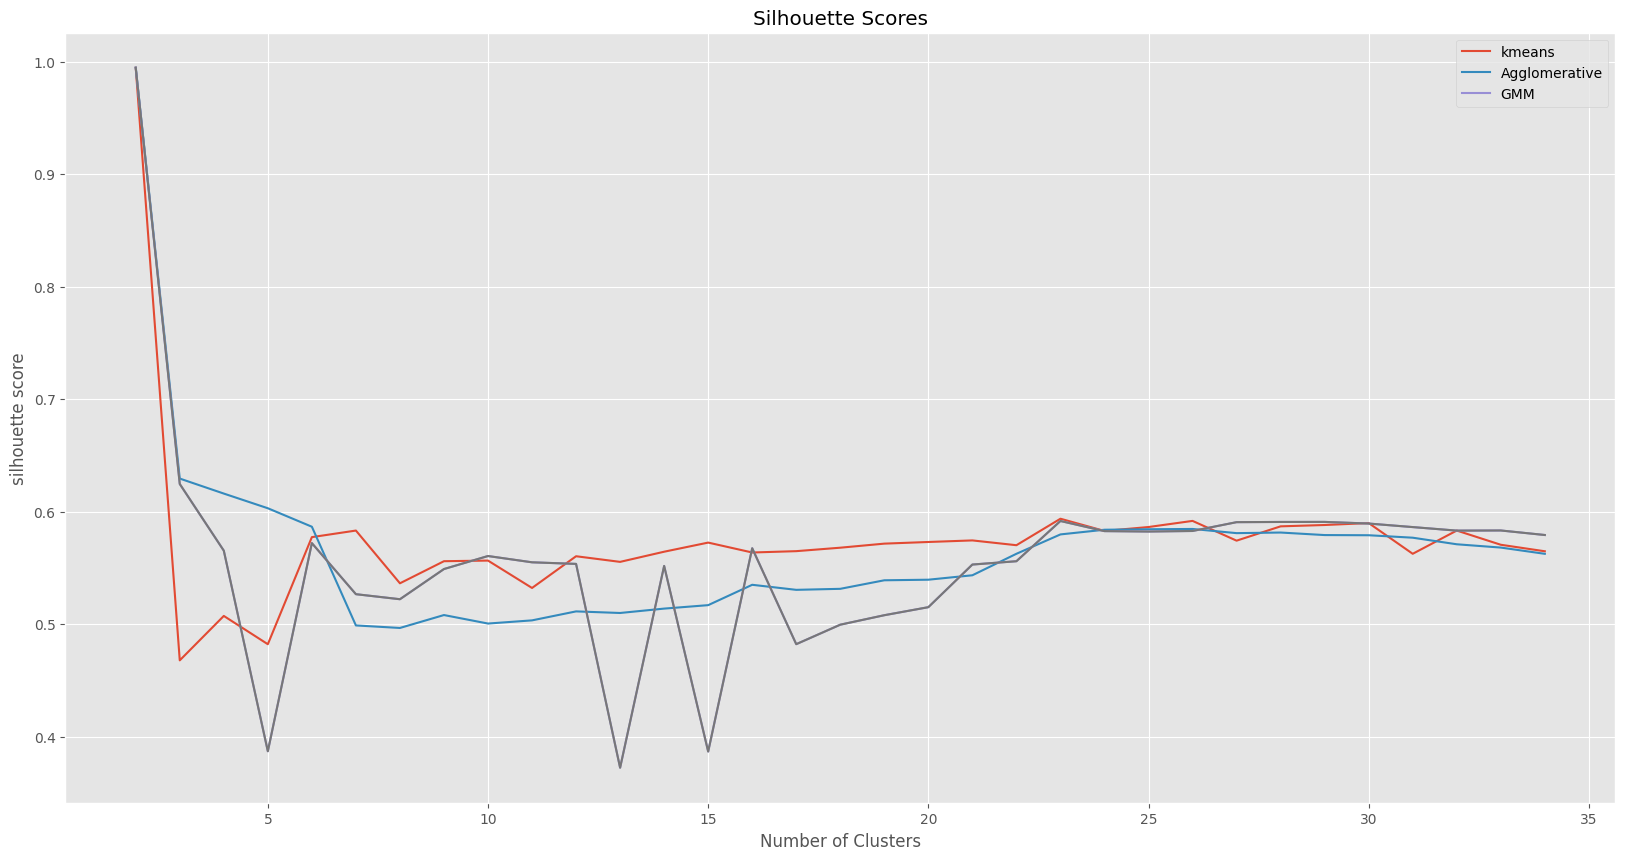

In [49]:
clusters=range(2,35,1)

# Compute the silhouette score for K means cluster within the range
scores = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0, n_init=10)
    labels = km.fit_predict(var_data_standardized_kmeans)
    score = silhouette_score(var_data_standardized_kmeans,labels)
    scores.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores)

# Compute the silhouette score for Agglomerative cluster within the range
scores = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(var_data_standardized_aglo)
    score = silhouette_score(var_data_standardized_aglo,labels)
    scores.append(score)

plt.plot(clusters,scores)

# Compute the silhouette score for GMM cluster within the range
scores = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(var_data_standardized_gmm)
    score = silhouette_score(var_data_standardized_gmm,labels)
    scores.append(score)

plt.plot(clusters,scores)

plt.plot(clusters,scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('silhouette score')
plt.legend(['kmeans','Agglomerative','GMM'])

### Davies-Bouldin Index

Davies-Bouldin Index K-Means: 0.34706578886689987
Davies-Bouldin Index GMM: 0.32648141756660487
Davies-Bouldin Index Agglomerative Clustering: 0.3519630051171271


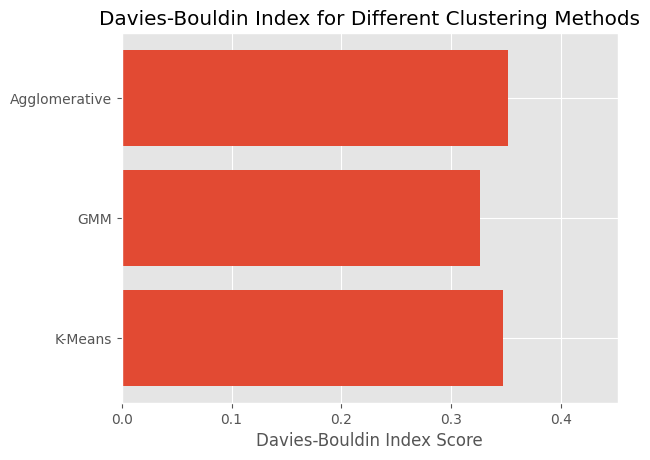

In [55]:
# Count Davies-Bouldin Index for every method of clustering
db_index_kmeans = davies_bouldin_score(var_data_standardized_kmeans, test1_clusters_kmeans)
db_index_gmm = davies_bouldin_score(var_data_standardized_gmm, test1_clusters_gmm)
db_index_aglo = davies_bouldin_score(var_data_standardized_aglo, test1_clusters_aglo)

# Display the result
print(f"Davies-Bouldin Index K-Means: {db_index_kmeans}")
print(f"Davies-Bouldin Index GMM: {db_index_gmm}")
print(f"Davies-Bouldin Index Agglomerative Clustering: {db_index_aglo}")

methods = ['K-Means', 'GMM', 'Agglomerative']
scores = [db_index_kmeans, db_index_gmm, db_index_aglo]

# Create a bar chart
plt.barh(methods, scores)
plt.xlabel('Davies-Bouldin Index Score')
plt.title('Davies-Bouldin Index for Different Clustering Methods')
plt.xlim([0, max(scores) + 0.1])  # Adjust the x-axis limits if needed

# Display the plot
plt.show()


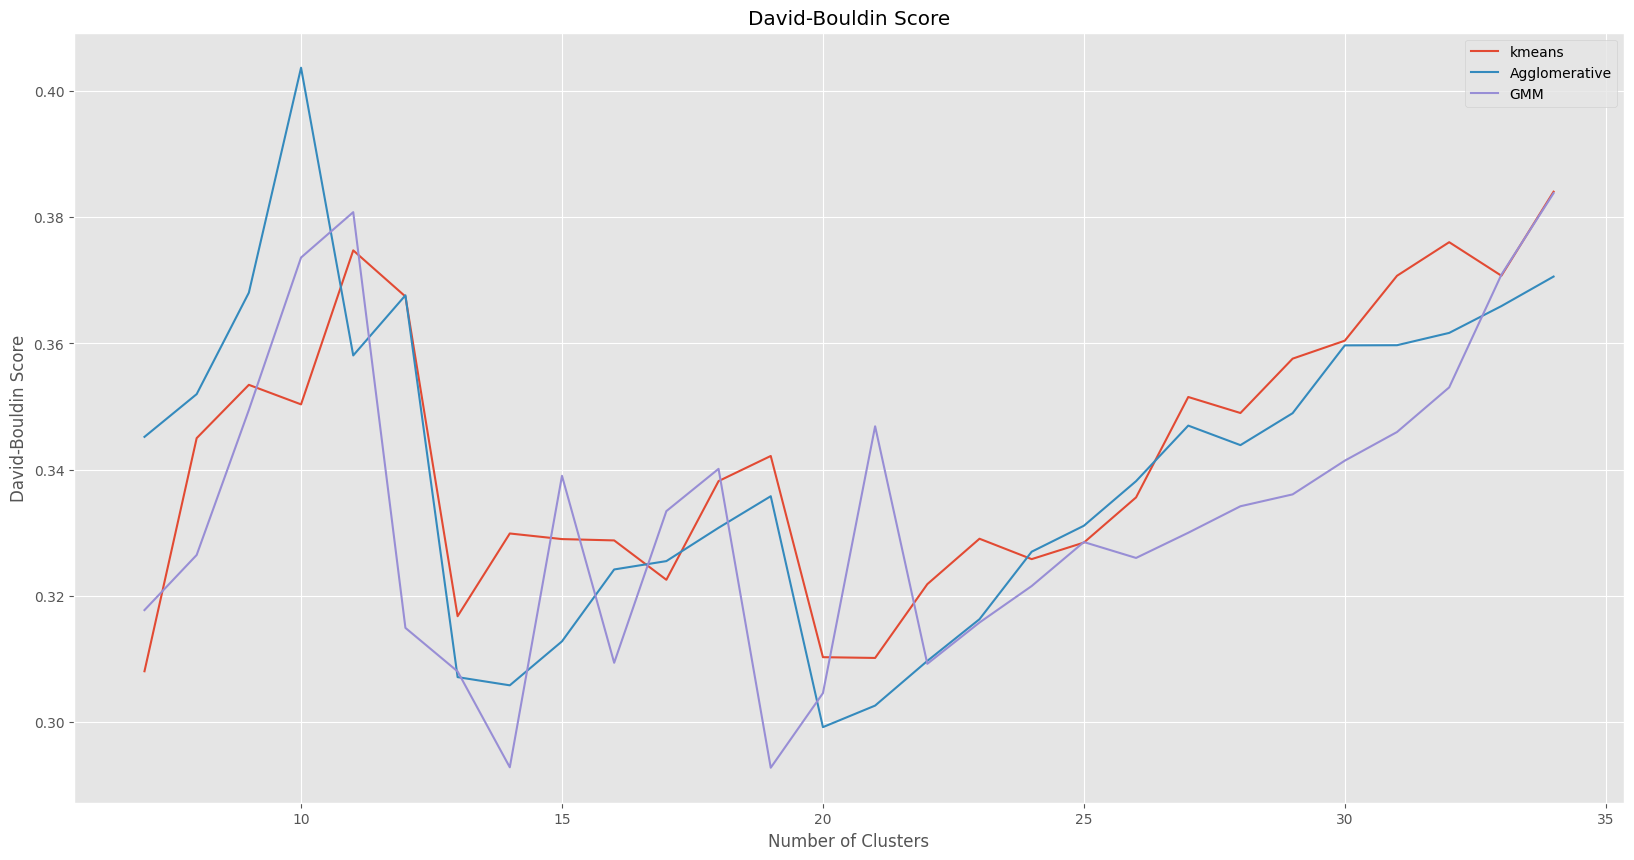

In [48]:
clusters=range(7,35,1)

# Compute the Davies Bouldin score for K means cluster within the range 
scores_dbi = []
for k in clusters:
    km = KMeans(n_clusters=k,random_state=0, n_init=10)
    labels = km.fit_predict(var_data_standardized_kmeans)
    score = davies_bouldin_score(var_data_standardized_kmeans,labels)
    scores_dbi.append(score)


plt.figure(figsize=(20,10))
plt.plot(clusters,scores_dbi)

# Compute the Davies Bouldin score for Agglomerative cluster within the range
scores_dbi = []
for k in clusters:
    ag = AgglomerativeClustering(n_clusters=k)
    labels = ag.fit_predict(var_data_standardized_aglo)
    score = davies_bouldin_score(var_data_standardized_aglo,labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

# Compute the Davies Bouldin score for GMM cluster within the range
scores_dbi = []
for k in clusters:
    gm =GaussianMixture(n_components=k, random_state=42)
    labels = gm.fit_predict(var_data_standardized_gmm)
    score = davies_bouldin_score(var_data_standardized_gmm,labels)
    scores_dbi.append(score)

plt.plot(clusters,scores_dbi)

plt.title('David-Bouldin Score')
plt.xlabel('Number of Clusters')
plt.ylabel('David-Bouldin Score')
plt.legend(['kmeans','Agglomerative','GMM'])

### Kesimpulan
Jadi, kesimpulan utamanya adalah bahwa dari dua metrik evaluasi yang digunakan, yaitu Silhouette Score dan Davies-Bouldin Index (DBI), KMeans menunjukkan hasil yang lebih baik. Meskipun GMM memiliki nilai DBI yang lebih baik, keunggulan KMeans terletak pada interpretasi yang lebih sederhana dan jelas dari hasil clustering-nya. Dengan grafik yang stabil dan nilai Silhouette Score yang tinggi, KMeans terbukti memberikan cluster yang konsisten dan terpisah dengan baik. Jadi, berdasarkan evaluasi yang telah dilakukan, KMeans menjadi pilihan terbaik dalam memahami pola cluster.